In [1]:
#importing the required libraries
import numpy as np
import pandas as pd
import pickle
import matrix_factorization_utilities
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [126]:
!pip install pymongo

In [128]:
import pymongo


In [133]:
from pymongo import MongoClient

In [134]:
Client = MongoClient('localhost',27017)

In [138]:
db = Client['MovieLens']

In [139]:
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'MovieLens')

In [2]:
# Reading the ratings data
ratings = pd.read_csv('Dataset/ratings.csv')

In [3]:
len(ratings)

1048575

In [5]:
#Just taking the required columns
ratings = ratings[['userId', 'movieId','rating']]

In [6]:
# Checking if the user has rated the same movie twice, in that case we just take max of them
ratings_df = ratings.groupby(['userId','movieId']).aggregate(np.max)

In [7]:
# In this case there are no such cases where the user has rated the same movie twice.
len(ratings_df)

1048575

In [8]:
# Inspecting the data
ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [9]:
ratings_df.head()

rating
userId movieId        
1      2           3.5
       29          3.5
       32          3.5
       47          3.5
       50          3.5

In [10]:
# Counting no of unique users
len(ratings['userId'].unique())

7120

In [11]:
#Getting the percentage count of each rating value 
count_ratings = ratings.groupby('rating').count()
count_ratings['perc_total']=round(count_ratings['userId']*100/count_ratings['userId'].sum(),1)

In [12]:
count_ratings

,userId,movieId,perc_total
rating,,,
0.5,13232,13232,1.3
1.0,35144,35144,3.4
1.5,14029,14029,1.3
2.0,74706,74706,7.1
2.5,44791,44791,4.3
3.0,226202,226202,21.6
3.5,112926,112926,10.8
4.0,295135,295135,28.1
4.5,79848,79848,7.6


<AxesSubplot:xlabel='rating'>

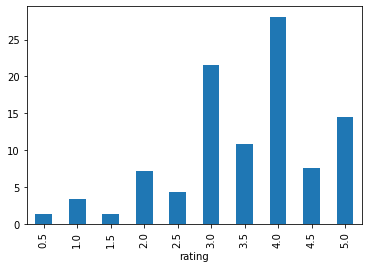

In [123]:
#Visualising the percentage total for each rating
count_ratings['perc_total'].plot.bar()

In [13]:
#reading the movies dataset
movie_list = pd.read_csv('Dataset/movies.csv')

In [14]:
len(movie_list)

27278

In [15]:
# insepcting the movie list dataframe
movie_list.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
# reading the tags datast
tags = pd.read_csv('Dataset/tags.csv')

In [17]:
# inspecting the tags data frame
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [18]:
# inspecting various genres
genres = movie_list['genres']

In [19]:
genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [20]:
genre_list = ""
for index,row in movie_list.iterrows():
        genre_list += row.genres + "|"
#split the string into a list of values
genre_list_split = genre_list.split('|')
#de-duplicate values
new_list = list(set(genre_list_split))
#remove the value that is blank
new_list.remove('')
#inspect list of genres
new_list

['Musical',
 'Documentary',
 'Action',
 'Mystery',
 'IMAX',
 'Animation',
 'Western',
 'Adventure',
 'Crime',
 'Comedy',
 'Sci-Fi',
 'War',
 'Horror',
 'Romance',
 'Fantasy',
 'Thriller',
 '(no genres listed)',
 'Children',
 'Film-Noir',
 'Drama']

In [21]:
#Enriching the movies dataset by adding the various genres columns.
movies_with_genres = movie_list.copy()

for genre in new_list :
    movies_with_genres[genre] = movies_with_genres.apply(lambda _:int(genre in _.genres), axis = 1)

In [22]:
movies_with_genres.head()

,movieId,title,genres,Musical,Documentary,Action,Mystery,IMAX,Animation,Western,...,Sci-Fi,War,Horror,Romance,Fantasy,Thriller,(no genres listed),Children,Film-Noir,Drama
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#Calculating the sparsity
no_of_users = len(ratings['userId'].unique())
no_of_movies = len(ratings['movieId'].unique())

sparsity = round(1.0 - len(ratings)/(1.0*(no_of_movies*no_of_users)),3)
print(sparsity)

0.99


In [24]:
# Counting the number of unique movies in the dataset.
len(ratings['movieId'].unique())

14026

In [25]:
# Finding the average rating for movie and the number of ratings for each movie
avg_movie_rating = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index

In [26]:
# inspecting the average movie rating data frame
avg_movie_rating.head()

,mean,count,movieId
movieId,,,
1,3.959323,2569,1
2,3.268398,1155,2
3,3.186861,685,3
4,3.000000,138,4
5,3.143836,657,5


In [27]:
len(avg_movie_rating)

14026

In [28]:
#calculate the percentile count. It gives the no of ratings at least 70% of the movies have
np.percentile(avg_movie_rating['count'],70)

30.0

In [29]:
#Get the average movie rating across all movies 
avg_rating_all=ratings['rating'].mean()
avg_rating_all
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=30
min_reviews
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.head()

,mean,count,movieId
movieId,,,
1,3.959323,2569,1
2,3.268398,1155,2
3,3.186861,685,3
4,3.000000,138,4
5,3.143836,657,5


In [30]:
len(movie_score)

4173

In [31]:
#create a function for weighted rating score based off count of reviews
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [32]:
#Calculating the weighted score for each movie
movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
movie_score.head()

<ipython-input-32-f069e78bacf9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)


,mean,count,movieId,weighted_score
movieId,,,,
1,3.959323,2569,1,3.954359
2,3.268398,1155,2,3.275003
3,3.186861,685,3,3.201228
4,3.000000,138,4,3.094513
5,3.143836,657,5,3.160667


In [35]:
#join movie details to movie ratings
#movie_score = pd.merge(movie_score,movies_with_genres,on='movieId')
#join movie links to movie ratings
#movie_score = pd.merge(movie_score,links,on='movieId')
movie_score.head()

,mean,count,movieId,weighted_score
movieId,,,,
1,3.959323,2569,1,3.954359
2,3.268398,1155,2,3.275003
3,3.186861,685,3,3.201228
4,3.000000,138,4,3.094513
5,3.143836,657,5,3.160667


In [37]:
# Gives the best movies according to genre based on weighted score which is calculated using IMDB formula
def best_movies_by_genre(genre,top_n):
    return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

In [42]:
# Creating a data frame that has user ratings accross all movies in form of matrix used in matrix factorisation
ratings_df = pd.pivot_table(ratings, index='userId', columns='movieId', aggfunc=np.max)

In [43]:
ratings_df.head()

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          NaN    3.5    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2          NaN    NaN    4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3          4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          NaN    NaN    NaN    NaN    NaN    3.0    NaN    NaN    NaN    4.0   
5          NaN    3.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

         ...                                                                 \
movieId  ... 129350 129354 129428 129707 130052 130073 130219 130462 130490   
userId   ...                                                                  
1        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 130642  
userId          
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  

[5 rows x 14026 columns]

In [45]:
ratings_df

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          NaN    3.5    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2          NaN    NaN    4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3          4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          NaN    NaN    NaN    NaN    NaN    3.0    NaN    NaN    NaN    4.0   
5          NaN    3.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
7116       4.0    NaN    NaN    NaN    3.5    NaN    NaN    NaN    NaN    NaN   
7117       4.0    NaN    4.0    NaN    NaN    5.0    3.0    NaN    1.0    3.0   
7118       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7119       5.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7120       4.5    4.0    NaN    NaN    NaN    NaN    4.0    NaN    NaN    NaN   

         ...                                                                 \
movieId  ... 129350 129354 129428 129707 130052 130073 130219 130462 130490   
userId   ...                                                                  
1        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
7116     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7117     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7118     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7119     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
7120     ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 130642  
userId          
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  
...        ...  
7116       NaN  
7117       NaN  
7118       NaN  
7119       NaN  
7120       NaN  

[7120 rows x 14026 columns]

In [46]:
#merging ratings and movies dataframes
ratings_movies = pd.merge(ratings,movie_list, on = 'movieId')

In [47]:
ratings_movies.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy


In [48]:
ratings_movies

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
...,...,...,...,...,...
1048570,7066,88572,1.5,Fred: The Movie (2010),Comedy
1048571,7066,112412,4.5,Perfect Sisters (2014),Drama|Mystery
1048572,7077,32013,3.5,Loop the Loop (Up and Down) (Horem pádem) (2004),Comedy
1048573,7086,102596,4.5,180° South (180 Degrees South) (180° South: Co...,Documentary|Drama


In [49]:
#Gets the other top 10 movies which are watched by the people who saw this particular movie
def get_other_movies(movie_name):
    #get all users who watched a specific movie
    df_movie_users_series = ratings_movies.loc[ratings_movies['title']==movie_name]['userId']
    #convert to a data frame
    df_movie_users = pd.DataFrame(df_movie_users_series,columns=['userId'])
    #get a list of all other movies watched by these users
    other_movies = pd.merge(df_movie_users,ratings_movies,on='userId')
    #get a list of the most commonly watched movies by these other user
    other_users_watched = pd.DataFrame(other_movies.groupby('title')['userId'].count()).sort_values('userId',ascending=False)
    other_users_watched['perc_who_watched'] = round(other_users_watched['userId']*100/other_users_watched['userId'][0],1)
    return other_users_watched[:10]

In [50]:
# Getting other top 10 movies which are watched by the people who saw 'Gone Girl'
get_other_movies('Gone Girl (2014)')

,userId,perc_who_watched
title,,
Gone Girl (2014),61,100.0
"Matrix, The (1999)",54,88.5
Inception (2010),53,86.9
Fight Club (1999),52,85.2
"Shawshank Redemption, The (1994)",52,85.2
"Dark Knight, The (2008)",52,85.2
"Lord of the Rings: The Fellowship of the Ring, The (2001)",51,83.6
"Lord of the Rings: The Return of the King, The (2003)",50,82.0
Pulp Fiction (1994),48,78.7


In [51]:
from sklearn.neighbors import NearestNeighbors


In [52]:
avg_movie_rating.head()

,mean,count,movieId
movieId,,,
1,3.959323,2569,1
2,3.268398,1155,2
3,3.186861,685,3
4,3.000000,138,4
5,3.143836,657,5


In [53]:
#only include movies with more than 10 ratings
movie_plus_10_ratings = avg_movie_rating.loc[avg_movie_rating['count']>=10]
print(len(movie_plus_10_ratings))

6870


In [54]:
movie_plus_10_ratings

,mean,count,movieId
movieId,,,
1,3.959323,2569,1
2,3.268398,1155,2
3,3.186861,685,3
4,3.000000,138,4
5,3.143836,657,5
...,...,...,...
116797,3.950000,40,116797
116823,3.600000,25,116823
117176,3.576923,13,117176


In [63]:
movies_with_genres.head()

,movieId,title,genres,Musical,Documentary,Action,Mystery,IMAX,Animation,Western,...,Sci-Fi,War,Horror,Romance,Fantasy,Thriller,(no genres listed),Children,Film-Noir,Drama
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(movie_content_df,movie_content_df)

In [66]:
# Similarity of the movies based on the content
cosine_sim

array([[5., 3., 1., ..., 1., 0., 2.],
       [3., 3., 0., ..., 1., 0., 2.],
       [1., 0., 2., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [2., 2., 0., ..., 1., 0., 3.]])

In [67]:
#create a series of the movie id and title
indicies = pd.Series(movie_content_df_temp.index, movie_content_df_temp['title'])
indicies 

title
Toy Story (1995)                          0
Jumanji (1995)                            1
Grumpier Old Men (1995)                   2
Waiting to Exhale (1995)                  3
Father of the Bride Part II (1995)        4
                                      ...  
Kein Bund für's Leben (2007)          27273
Feuer, Eis & Dosenbier (2002)         27274
The Pirates (2014)                    27275
Rentun Ruusu (2001)                   27276
Innocence (2014)                      27277
Length: 27278, dtype: int64

In [68]:
#Gets the top 10 similar movies based on the content
def get_similar_movies_based_on_content(movie_index) :
    sim_scores = list(enumerate(cosine_sim[movie_index]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
   
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[0:11]
    print(sim_scores)
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    print(movie_indices)
    similar_movies = pd.DataFrame(movie_content_df_temp[['title','genres']].iloc[movie_indices])
    return similar_movies

In [69]:
indicies["Skyfall (2012)"]

19338

In [70]:
get_similar_movies_based_on_content(19338)

[(6260, 4.0), (6822, 4.0), (11018, 4.0), (11826, 4.0), (15203, 4.0), (16733, 4.0), (18315, 4.0), (18349, 4.0), (19338, 4.0), (20615, 4.0), (9, 3.0)]
[6260, 6822, 11018, 11826, 15203, 16733, 18315, 18349, 19338, 20615, 9]


,title,genres
6260,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
6822,"Matrix Revolutions, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
11018,Poseidon (2006),Action|Adventure|Thriller|IMAX
11826,Spider-Man 3 (2007),Action|Adventure|Sci-Fi|Thriller|IMAX
15203,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX
16733,Sanctum (2011),Action|Adventure|Drama|Thriller|IMAX
18315,"Bourne Legacy, The (2012)",Action|Adventure|Drama|Thriller|IMAX
18349,Mission: Impossible - Ghost Protocol (2011),Action|Adventure|Thriller|IMAX
19338,Skyfall (2012),Action|Adventure|Thriller|IMAX
20615,G.I. Joe: Retaliation (2013),Action|Adventure|Sci-Fi|Thriller|IMAX


In [71]:
#get ordered list of movieIds
item_indices = pd.DataFrame(sorted(list(set(ratings['movieId']))),columns=['movieId'])
#add in data frame index value to data frame
item_indices['movie_index']=item_indices.index
#inspect data frame
item_indices.head()


,movieId,movie_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [72]:
#get ordered list of movieIds
user_indices = pd.DataFrame(sorted(list(set(ratings['userId']))),columns=['userId'])
#add in data frame index value to data frame
user_indices['user_index']=user_indices.index
#inspect data frame
user_indices.head()

,userId,user_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [73]:
#join the movie indices
df_with_index = pd.merge(ratings,item_indices,on='movieId')
#join the user indices
df_with_index=pd.merge(df_with_index,user_indices,on='userId')
#inspec the data frame
df_with_index.head()

,userId,movieId,rating,movie_index,user_index
0,1,2,3.5,1,0
1,1,29,3.5,28,0
2,1,32,3.5,31,0
3,1,47,3.5,46,0
4,1,50,3.5,49,0


In [74]:
#import train_test_split module
from sklearn.model_selection import train_test_split
#take 80% as the training set and 20% as the test set
df_train, df_test= train_test_split(df_with_index,test_size=0.2)
print(len(df_train))
print(len(df_test))

838860
209715


In [75]:
df_train.head()

,userId,movieId,rating,movie_index,user_index
242444,4141,4855,4.0,4610,4140
918008,1932,1240,4.0,1183,1931
371415,6578,2105,3.0,1965,6577
282164,4760,2701,1.0,2546,4759
474066,6570,6448,4.0,6063,6569


In [76]:
df_test.head()

,userId,movieId,rating,movie_index,user_index
8328,220,589,4.0,577,219
858354,2556,3702,5.0,3489,2555
985257,1838,648,4.0,628,1837
873741,306,1270,5.0,1213,305
239617,4114,1748,4.0,1637,4113


In [77]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]
print(n_users)
print(n_items)

7120
14026


In [78]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_train.itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    train_data_matrix[line[5], line[4]] = line[3]
train_data_matrix.shape

(7120, 14026)

In [79]:
#Create two user-item matrices, one for training and another for testing
test_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_test[:1].itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    #print(line[2])
    test_data_matrix[line[5], line[4]] = line[3]
    #train_data_matrix[line['movieId'], line['userId']] = line['rating']
test_data_matrix.shape

(7120, 14026)

In [80]:
pd.DataFrame(train_data_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,14016,14017,14018,14019,14020,14021,14022,14023,14024,14025
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
df_train['rating'].max()

5.0

In [82]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    #select prediction values that are non-zero and flatten into 1 array
    prediction = prediction[ground_truth.nonzero()].flatten() 
    #select test values that are non-zero and flatten into 1 array
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    #return RMSE between values
    return sqrt(mean_squared_error(prediction, ground_truth))

In [83]:
#Calculate the rmse sscore of SVD using different values of k (latent features)
rmse_list = []
for i in [1,2,5,20,40,60,100,200]:
    #apply svd to the test data
    u,s,vt = svds(train_data_matrix,k=i)
    #get diagonal matrix
    s_diag_matrix=np.diag(s)
    #predict x with dot product of u s_diag and vt
    X_pred = np.dot(np.dot(u,s_diag_matrix),vt)
    #calculate rmse score of matrix factorisation predictions
    rmse_score = rmse(X_pred,test_data_matrix)
    rmse_list.append(rmse_score)
    print("Matrix Factorisation with " + str(i) +" latent features has a RMSE of " + str(rmse_score))

Matrix Factorisation with 1 latent features has a RMSE of 1.2321682514257044
Matrix Factorisation with 2 latent features has a RMSE of 1.9794635751672796
Matrix Factorisation with 5 latent features has a RMSE of 1.8528515875076197
Matrix Factorisation with 20 latent features has a RMSE of 1.8015374170956209
Matrix Factorisation with 40 latent features has a RMSE of 2.837974190498138
Matrix Factorisation with 60 latent features has a RMSE of 4.108415408506451
Matrix Factorisation with 100 latent features has a RMSE of 4.919635604129794
Matrix Factorisation with 200 latent features has a RMSE of 4.022833892063328


In [84]:
#Convert predictions to a DataFrame
mf_pred = pd.DataFrame(X_pred)
mf_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,14016,14017,14018,14019,14020,14021,14022,14023,14024,14025
0,0.067680,0.885969,-0.083281,-0.151073,-0.088295,0.371672,-0.255081,-0.056970,0.085880,-0.276565,...,-0.003628,-0.001722,-0.023148,0.000232,0.0,0.0,-0.023022,-0.012551,0.001176,-0.011878
1,-0.141047,0.073639,0.612843,0.058300,0.149588,-0.214382,0.022916,-0.071724,0.116958,0.626313,...,0.009506,-0.011491,-0.021179,0.000951,0.0,0.0,-0.007575,0.002970,-0.008278,-0.006586
2,0.370156,0.080704,-0.139470,-0.022799,-0.135867,-0.980470,0.010626,-0.163654,-0.047588,0.494252,...,0.013458,0.000721,-0.050899,-0.000580,0.0,0.0,-0.011953,0.021501,0.011992,-0.006528
3,-0.016052,0.530741,0.361764,-0.039605,0.282974,1.980628,0.308854,0.033126,0.145851,0.542143,...,-0.001073,-0.006231,-0.010794,0.000244,0.0,0.0,-0.006317,-0.003509,0.021041,-0.002984
4,0.201394,1.424531,0.805778,-0.055451,0.573586,0.212149,0.804513,0.123054,0.113345,-0.264423,...,0.004927,0.018756,0.005877,0.000427,0.0,0.0,-0.004865,-0.012855,0.015057,0.004634


In [85]:
df_names = pd.merge(ratings,movie_list,on='movieId')
df_names.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy


In [86]:
#choose a user ID
user_id = 1
#get movies rated by this user id
users_movies = df_names.loc[df_names["userId"]==user_id]
#print how many ratings user has made 
print("User ID : " + str(user_id) + " has already rated " + str(len(users_movies)) + " movies")
#list movies that have been rated
users_movies

User ID : 1 has already rated 175 movies


,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1155,1,29,3.5,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
1603,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3915,1,47,3.5,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
6156,1,50,3.5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
130066,1,8507,5.0,Freaks (1932),Crime|Drama|Horror
130115,1,8636,4.5,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX
130973,1,8690,3.5,Slaughterhouse-Five (1972),Comedy|Drama|Sci-Fi|War
131002,1,8961,4.0,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy


In [87]:
user_index = df_train.loc[df_train["userId"]==user_id]['user_index'][:1].values[0]
#get movie ratings predicted for this user and sort by highest rating prediction
sorted_user_predictions = pd.DataFrame(mf_pred.iloc[user_index].sort_values(ascending=False))
#rename the columns
sorted_user_predictions.columns=['ratings']
#save the index values as movie id
sorted_user_predictions['movieId']=sorted_user_predictions.index
print("Top 10 predictions for User " + str(user_id))
#display the top 10 predictions for this user
pd.merge(sorted_user_predictions,movie_list, on = 'movieId')[:10]

Top 10 predictions for User 1


,ratings,movieId,title,genres
0,5.587314,4738,Happy Accidents (2000),Romance|Sci-Fi
1,5.114176,5622,Charly (2002),Comedy|Drama|Romance
2,4.982981,1159,Love in Bloom (1935),Romance
3,4.551656,6699,Once Upon a Time in the Midlands (2002),Drama
4,4.462700,254,Jefferson in Paris (1995),Drama
5,4.123286,1052,"Proprietor, The (1996)",Drama
6,4.017748,1144,"Line King: The Al Hirschfeld Story, The (1996)",Documentary
7,3.822917,1142,Get Over It (1996),Drama
8,3.800571,312,Stuart Saves His Family (1995),Comedy
9,3.778310,287,Nina Takes a Lover (1994),Comedy|Romance


In [88]:
#count number of unique users
numUsers = df_train.userId.unique().shape[0]
#count number of unitque movies
numMovies = df_train.movieId.unique().shape[0]
print(len(df_train))
print(numUsers) 
print(numMovies) 

838860
7120
13427


In [89]:
#Separate out the values of the df_train data set into separate variables
Users = df_train['userId'].values
Movies = df_train['movieId'].values
Ratings = df_train['rating'].values
print(Users),print(len(Users))
print(Movies),print(len(Movies))
print(Ratings),print(len(Ratings))

[4141 1932 6578 ... 3800 1972 4558]
838860
[4855 1240 2105 ... 3095 4370 7137]
838860
[4. 4. 3. ... 5. 5. 3.]
838860


(None, None)

In [91]:
#import libraries
import keras

from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [92]:
from keras.utils import plot_model

ImportError: cannot import name 'plot_model' from 'keras.utils' (C:\Users\Rahmat\anaconda3\lib\site-packages\keras\utils\__init__.py)

In [93]:
# Couting no of unique users and movies
len(ratings.userId.unique()), len(ratings.movieId.unique())

(7120, 14026)

In [94]:
# Assigning a unique value to each user and movie in range 0,no_of_users and 0,no_of_movies respectively.
ratings.userId = ratings.userId.astype('category').cat.codes.values
ratings.movieId = ratings.movieId.astype('category').cat.codes.values

In [95]:
# Splitting the data into train and test.
train, test = train_test_split(ratings, test_size=0.2)

In [96]:
train.head()

,userId,movieId,rating
568815,3814,1049,0.5
926532,6174,9038,4.5
62173,435,1234,4.5
784867,5224,21,3.0
441762,3007,1985,0.5


In [97]:
test.head()

,userId,movieId,rating
903239,6053,756,4.0
60642,424,1150,5.0
315217,2155,337,3.0
1040252,7050,1341,3.0
328430,2238,4123,2.0


In [98]:
n_users, n_movies = len(ratings.userId.unique()), len(ratings.movieId.unique())

In [99]:
# Returns a neural network model which performs matrix factorisation
def matrix_factorisation_model_with_n_latent_factors(n_latent_factors) :
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))
    prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
    
    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [109]:
from keras.constraints import non_neg

In [110]:
# Returns a neural network model which performs matrix factorisation with additional constraint on embeddings(that they can't be negative)
def matrix_factorisation_model_with_n_latent_factors_and_non_negative_embedding(n_latent_factors) :
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Non-Negative-Movie-Embedding',embeddings_constraint=non_neg())(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='Non-Negative-User-Embedding',embeddings_constraint=non_neg())(user_input))
    prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
    
    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [124]:
# Returns a neural network model which does recommendation
def neural_network_model(n_latent_factors_user, n_latent_factors_movie):
    
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
    movie_vec = keras.layers.Dropout(0.2)(movie_vec)


    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
    user_vec = keras.layers.Dropout(0.2)(user_vec)


    concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
    concat_dropout = keras.layers.Dropout(0.2)(concat)
    dense = keras.layers.Dense(100,name='FullyConnected')(concat)
    dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
    dense_2 = keras.layers.Dense(50,name='FullyConnected-1')(concat)
    dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
    dense_3 = keras.layers.Dense(20,name='FullyConnected-2')(dense_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
    dense_4 = keras.layers.Dense(10,name='FullyConnected-3', activation='relu')(dense_3)


    result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
    adam = Adam(lr=0.005)
    model = keras.Model([user_input, movie_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model